# 01 – EDA for SROIE Receipts (Raw vs Adaptive Preprocessing)

This notebook performs exploratory data analysis (EDA) on the **SROIE 2019** receipt dataset.

Goals:
- Inspect **raw** receipt images (`data/raw/SROIE2019/train/img`).
- Inspect **preprocessed** images (`data/processed/SROIE2019/train`).
- Quantify image sizes and grayscale statistics (mean, std / contrast).
- Visually compare *Raw vs Processed* receipts.
- Justify the **adaptive preprocessing** strategy used in the project.

In [35]:
from pathlib import Path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

RAW_ROOT = Path("../data/raw/SROIE2019")
PROC_ROOT = Path("../data/processed/SROIE2019")

RAW_TRAIN_IMG = RAW_ROOT / "train" / "img"
RAW_TEST_IMG  = RAW_ROOT / "test" / "img"

PROC_TRAIN_IMG = PROC_ROOT / "train"
PROC_TEST_IMG  = PROC_ROOT / "test"

print("Raw train dir :", RAW_TRAIN_IMG)
print("Raw test dir  :", RAW_TEST_IMG)
print("Proc train dir:", PROC_TRAIN_IMG)
print("Proc test dir :", PROC_TEST_IMG)

for p in [RAW_TRAIN_IMG, RAW_TEST_IMG, PROC_TRAIN_IMG, PROC_TEST_IMG]:
    print(p, "exists:", p.exists())

Raw train dir : ../data/raw/SROIE2019/train/img
Raw test dir  : ../data/raw/SROIE2019/test/img
Proc train dir: ../data/processed/SROIE2019/train
Proc test dir : ../data/processed/SROIE2019/test
../data/raw/SROIE2019/train/img exists: True
../data/raw/SROIE2019/test/img exists: True
../data/processed/SROIE2019/train exists: True
../data/processed/SROIE2019/test exists: True


## 1. Image Counts (Raw vs Processed)

In [36]:
def count_images(folder: Path, exts=(".jpg", ".jpeg", ".png", ".tif", ".tiff")):
    if not folder.exists():
        return 0
    return sum(1 for f in folder.iterdir() if f.suffix.lower() in exts)

summary = {
    "raw_train": count_images(RAW_TRAIN_IMG),
    "raw_test": count_images(RAW_TEST_IMG),
    "proc_train": count_images(PROC_TRAIN_IMG),
    "proc_test": count_images(PROC_TEST_IMG)
}
summary

{'raw_train': 626, 'raw_test': 347, 'proc_train': 626, 'proc_test': 347}

## 2. Sample Filenames
Quick sanity check on what the dataset looks like on disk.

In [37]:
def sample_files(folder: Path, n=5):
    if not folder.exists():
        return []
    files = [f for f in folder.iterdir() if f.is_file()]
    return sorted(files)[:n]

print("Raw train samples:")
for f in sample_files(RAW_TRAIN_IMG):
    print("  ", f.name)

print("\nProcessed train samples:")
for f in sample_files(PROC_TRAIN_IMG):
    print("  ", f.name)

Raw train samples:
   X00016469612.jpg
   X00016469619.jpg
   X00016469620.jpg
   X00016469622.jpg
   X00016469623.jpg

Processed train samples:
   X00016469612.jpg
   X00016469619.jpg
   X00016469620.jpg
   X00016469622.jpg
   X00016469623.jpg


## 3. Image Size & Aspect Ratio Statistics

We inspect height, width, and aspect ratio distributions for **raw** and **processed** images in the train set.

In [38]:
def collect_size_stats(folder: Path, max_images=500):
    widths, heights, aspects = [], [], []
    if not folder.exists():
        return widths, heights, aspects
    files = [f for f in folder.iterdir() if f.is_file()]
    for f in files[:max_images]:
        try:
            with Image.open(f) as img:
                w, h = img.size
            widths.append(w)
            heights.append(h)
            aspects.append(w / h if h != 0 else np.nan)
        except Exception as e:
            print("Failed to open", f, ":", e)
    return widths, heights, aspects

raw_w, raw_h, raw_a = collect_size_stats(RAW_TRAIN_IMG)
proc_w, proc_h, proc_a = collect_size_stats(PROC_TRAIN_IMG)

print("Raw train images analyzed:      ", len(raw_w))
print("Processed train images analyzed:", len(proc_w))

Raw train images analyzed:       500
Processed train images analyzed: 500


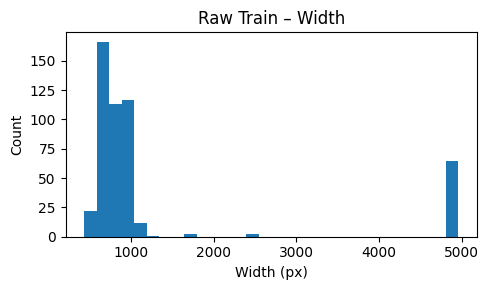

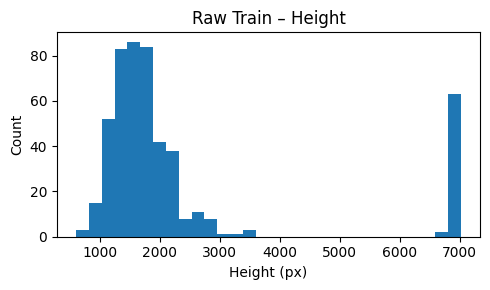

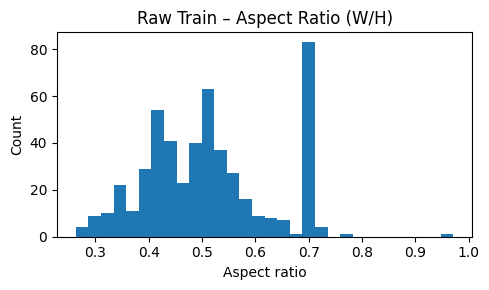

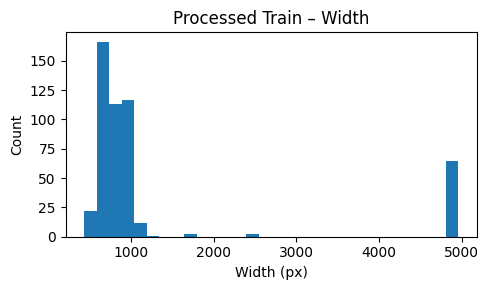

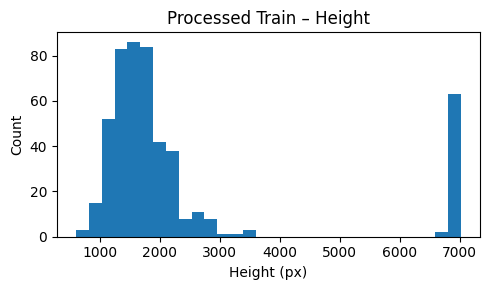

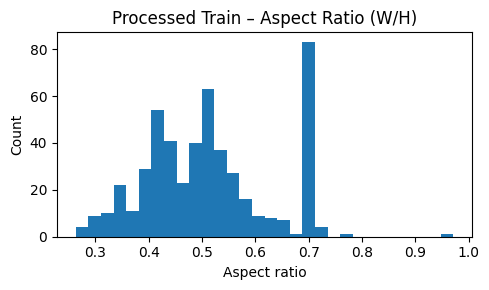

In [39]:
def plot_hist(data, title, xlabel):
    if not data:
        print("No data for", title)
        return
    plt.figure(figsize=(5,3))
    plt.hist(data, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_hist(raw_w,  "Raw Train – Width", "Width (px)")
plot_hist(raw_h,  "Raw Train – Height", "Height (px)")
plot_hist(raw_a,  "Raw Train – Aspect Ratio (W/H)", "Aspect ratio")

plot_hist(proc_w, "Processed Train – Width", "Width (px)")
plot_hist(proc_h, "Processed Train – Height", "Height (px)")
plot_hist(proc_a, "Processed Train – Aspect Ratio (W/H)", "Aspect ratio")

## 4. Grayscale Statistics (Mean & Std = Brightness & Contrast)

We compute per-image grayscale **mean** and **standard deviation (std)** for raw and processed images.

- **Mean** ≈ brightness
- **Std** ≈ contrast

These metrics are used by our adaptive preprocessing to decide between `light`, `medium`, and `heavy` modes.

In [40]:
def collect_gray_stats(folder: Path, max_images=500):
    means, stds = [], []
    if not folder.exists():
        return means, stds
    files = [f for f in folder.iterdir() if f.is_file()]
    for f in files[:max_images]:
        try:
            with Image.open(f) as img:
                gray = img.convert("L")
                arr = np.array(gray, dtype=np.float32)
            means.append(float(arr.mean()))
            stds.append(float(arr.std()))
        except Exception as e:
            print("Failed to open", f, ":", e)
    return means, stds

raw_mean, raw_std   = collect_gray_stats(RAW_TRAIN_IMG)
proc_mean, proc_std = collect_gray_stats(PROC_TRAIN_IMG)

print("Raw   mean/std examples:", raw_mean[:3], raw_std[:3])
print("Proc. mean/std examples:", proc_mean[:3], proc_std[:3])

Raw   mean/std examples: [252.76844787597656, 246.36282348632812, 237.8603057861328] [20.851999282836914, 30.47798728942871, 43.88176345825195]
Proc. mean/std examples: [252.41329956054688, 242.0704803466797, 226.52731323242188] [20.574342727661133, 35.203269958496094, 41.198707580566406]


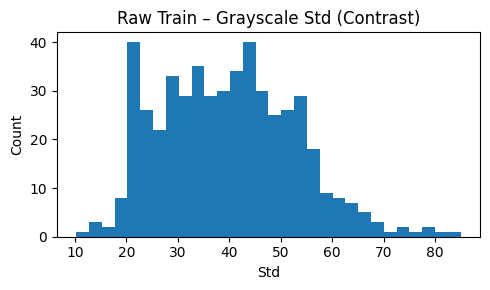

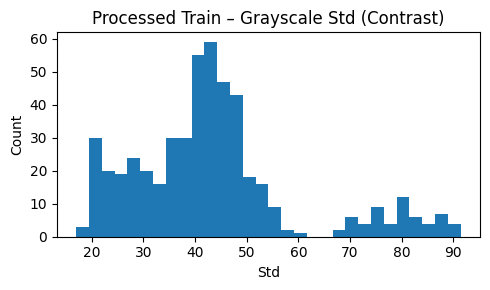

In [41]:
plot_hist(raw_std,  "Raw Train – Grayscale Std (Contrast)", "Std")
plot_hist(proc_std, "Processed Train – Grayscale Std (Contrast)", "Std")

### Thresholds Used in Adaptive Preprocessing

From these histograms, we empirically set thresholds:

- **std < 30** → very faint receipts → `light` preprocessing
- **30 ≤ std ≤ 55** → typical receipts → `medium` preprocessing
- **std > 55** → strong contrast / shadows → `heavy` preprocessing

These thresholds match visual categories observed during manual inspection.

## 5. Visual Comparison: Raw vs Processed

We now visually compare a few receipts side by side to qualitatively assess the effect of preprocessing.

Sample: X51005568899


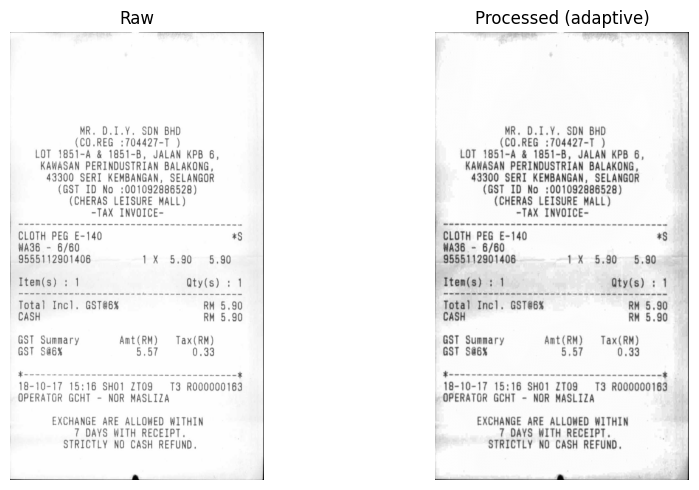

Sample: X51006311778


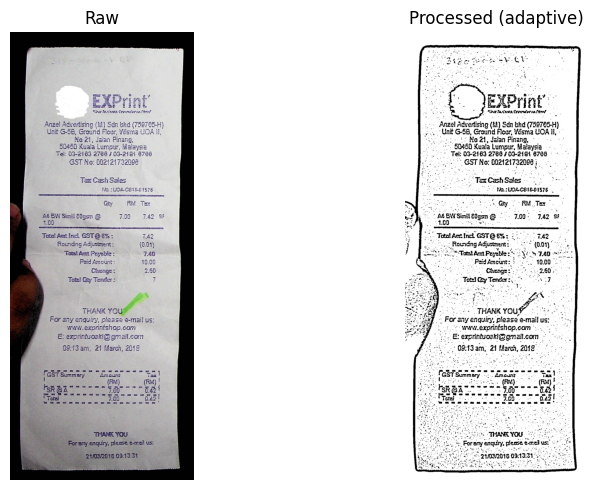

Sample: X51006556830


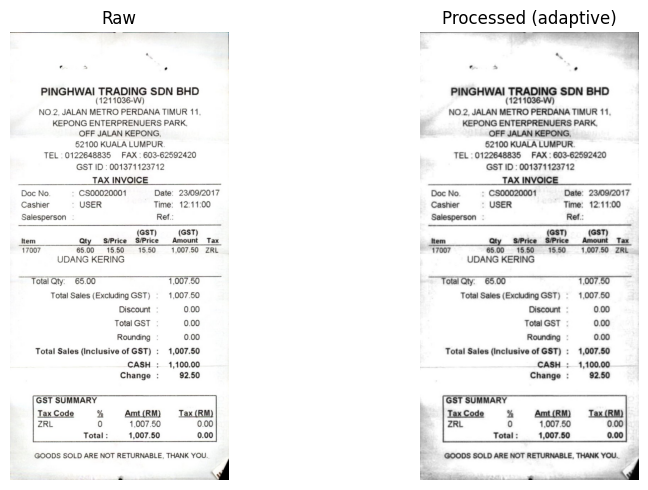

Sample: X51005676540


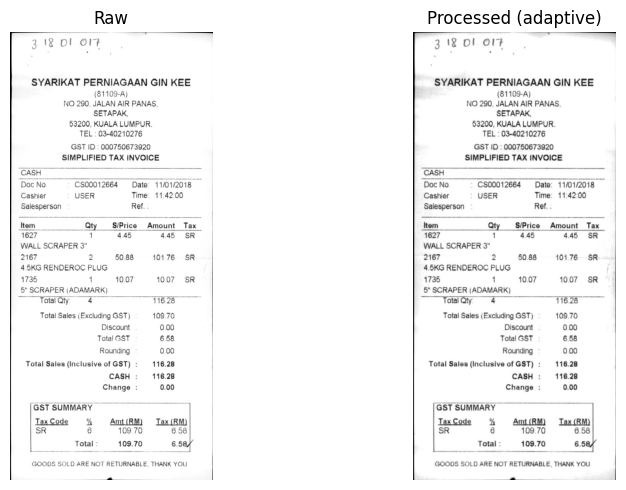

In [42]:
def show_raw_vs_processed(raw_dir: Path, proc_dir: Path, n=4):
    if not raw_dir.exists() or not proc_dir.exists():
        print("One of the directories does not exist.")
        return

    raw_files  = [f for f in raw_dir.iterdir() if f.is_file()]
    proc_files = [f for f in proc_dir.iterdir() if f.is_file()]

    raw_by_stem  = {f.stem: f for f in raw_files}
    proc_by_stem = {f.stem: f for f in proc_files}

    common = list(set(raw_by_stem.keys()) & set(proc_by_stem.keys()))
    if not common:
        print("No common stems between raw and processed.")
        return

    random.shuffle(common)
    samples = common[:n]

    for stem in samples:
        raw_path  = raw_by_stem[stem]
        proc_path = proc_by_stem[stem]

        print(f"Sample: {stem}")
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        with Image.open(raw_path) as img_raw:
            axes[0].imshow(img_raw)
            axes[0].set_title("Raw")
            axes[0].axis("off")

        with Image.open(proc_path) as img_proc:
            axes[1].imshow(img_proc, cmap="gray")
            axes[1].set_title("Processed (adaptive)")
            axes[1].axis("off")

        plt.tight_layout()
        plt.show()

show_raw_vs_processed(RAW_TRAIN_IMG, PROC_TRAIN_IMG, n=4)

## 6. Notes for Technical Report – EDA & Preprocessing Section

- The SROIE dataset contains receipts with **high variability** in contrast, illumination, and scan quality.
- Some receipts are **colored / shadowed**, others are **clean grayscale**, and some are **very faint**.
- Simple global preprocessing (same steps for all images) **degraded** some receipts (e.g., thresholding removed faint text, deskew rotated wrongly).
- By measuring grayscale **standard deviation (std)** per image, we identified three natural groups:
  - `std < 30` → faint receipts
  - `30–55` → normal receipts
  - `>55` → high-contrast / shadowed receipts
- We therefore designed an **adaptive preprocessing strategy**:
  - `light` for faint receipts (mild denoise + CLAHE)
  - `medium` for typical receipts (Gaussian blur + CLAHE)
  - `heavy` for shadowed receipts (Gaussian blur + adaptive threshold)
- Visual inspection of raw vs processed images confirms that adaptive preprocessing **enhances readability** where needed while **avoiding degradation** on already-faint receipts.